## Applications of Machine Learning in Remote Sensing
### Homework 3
#### Nakul Poudel - np1140@rit.edu

#### https://github.com/np1140/MLRemoteSensing/

####  Classification

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = loadmat('PaviaU.mat')
gt = loadmat('PaviaU_gt.mat')
X = data['paviaU']
Y = gt['paviaU_gt']
print("Data shape:", X.shape)
print("GT shape:", Y.shape)
num_classes = len(np.unique(Y)) - 1 # Exclude background class
print("Number of classes (excluding background):", num_classes)
print("Data type:", X.dtype)
print("GT type:", Y.dtype)
print("Data min/max:", X.min(), X.max())
print("GT min/max:", Y.min(), Y.max())
print("Data mean/std:", X.mean(), X.std())
print("GT mean/std:", Y.mean(), Y.std())
print("Number of non-zero GT labels:", np.count_nonzero(Y))
print("Number of zero GT labels (background):", np.size(Y) - np.count_nonzero(Y))
print("Unique GT labels:", np.unique(Y))
print("Data sample (5 pixels):", X.reshape(-1, X.shape[2])[:5])
print("GT sample (5 pixels):", Y.reshape(-1)[:5])
print("Data shape after reshaping:", X.reshape(-1, X.shape[2]).shape)
print("GT shape after reshaping:", Y.reshape(-1).shape)

Data shape: (610, 340, 103)
GT shape: (610, 340)
Number of classes (excluding background): 9
Data type: uint16
GT type: uint8
Data min/max: 0 8000
GT min/max: 0 9
Data mean/std: 1389.1253099399873 897.6575399774091
GT mean/std: 0.7071841851494696 1.753372965966647
Number of non-zero GT labels: 42776
Number of zero GT labels (background): 164624
Unique GT labels: [0 1 2 3 4 5 6 7 8 9]
Data sample (5 pixels): [[ 647  499  464  371  291  319  365  322  296  305  277  219  219  222
   201  162  157  183  204  194  198  216  249  284  294  322  338  342
   336  342  362  365  348  341  324  316  293  274  251  244  263  248
   236  254  255  240  223  203  202  191  185  200  203  181  168  174
   185  187  165  151  144  140  149  169  192  227  287  376  493  633
   763  913 1149 1442 1759 2102 2425 2689 2895 3058 3196 3252 3195 3297
  3542 3550 3537 3545 3514 3477 3468 3433 3408 3420 3416 3335 3256 3226
  3205 3210 3221 3238 3250]
 [ 604  546  527  455  378  377  336  314  324  329  328 

Since the task involves classifying pixels into multiple classes, it is important to know the proportion of pixels belonging to each class, including those representing the background. It is also necessary to understand how background pixels are represented, whether as zero values or some other coding. Also, the total number of classes is important to consider.

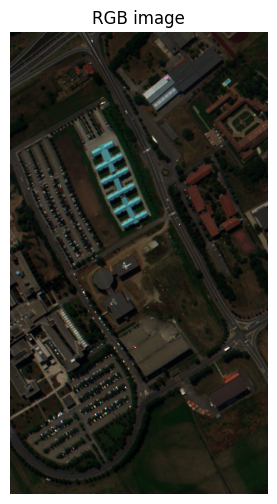

In [3]:
rgb_bands = [60, 30, 10]
rgb_image = X[:, :, rgb_bands]

# Normalize
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

plt.figure(figsize=(7, 6))
plt.imshow(rgb_image)
plt.title(f"RGB image")
plt.axis('off')
plt.show()


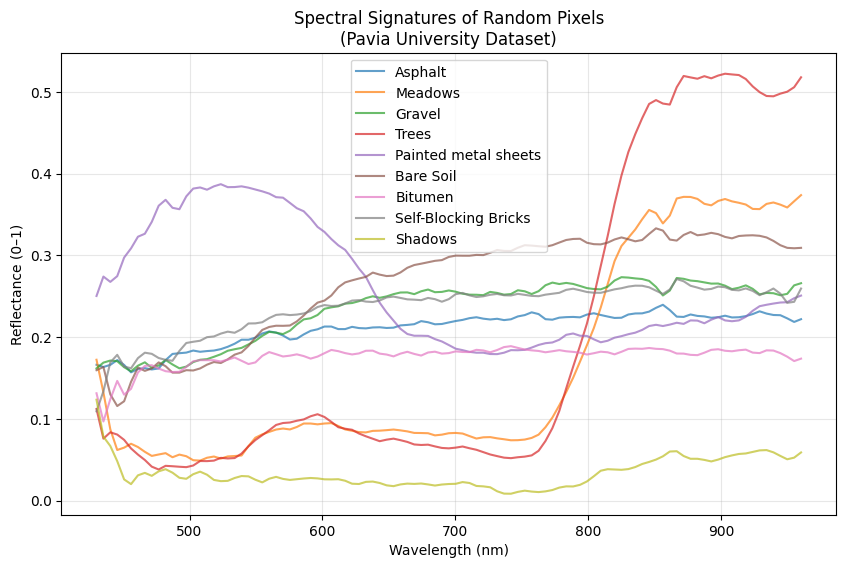

In [4]:
start_wavelength = 430  # nm
end_wavelength = 960    # nm
num_bands = X.shape[-1]
wavelengths = np.linspace(start_wavelength, end_wavelength, num_bands)

# Reflectance normalized to 0-1
X_norm = (X - X.min()) / (X.max() - X.min())

# Define class labels and names
class_names = {
    1: "Asphalt",
    2: "Meadows",
    3: "Gravel",
    4: "Trees",
    5: "Painted metal sheets",
    6: "Bare Soil",
    7: "Bitumen",
    8: "Self-Blocking Bricks",
    9: "Shadows"
}

np.random.seed(2)
samples_per_class = 1

plt.figure(figsize=(10, 6))
for c in np.unique(Y)[1:]:  # skip background (0)
    y_idx, x_idx = np.where(Y == c)
    rand_pixels = np.random.choice(len(x_idx), samples_per_class, replace=False)
    for i in rand_pixels:
        spectrum = X_norm[y_idx[i], x_idx[i], :]
        plt.plot(
            wavelengths,
            spectrum,
            label=class_names[c] if i == rand_pixels[0] else "",
            alpha=0.7
        )

plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (0–1)')
plt.title('Spectral Signatures of Random Pixels\n(Pavia University Dataset)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The spectral plot illustrates the reflectance characteristics of different classes across various wavelength bands. Shadow exhibits the lowest reflectance across all wavelengths. The painted metal sheet shows high reflectance in the visible range, which decreases toward the near-infrared (NIR) region. In contrast, both tree and meadow classes display a sharp increase in reflectance in the NIR region, indicating healthy vegetation.

### Class distribution in ground truth data

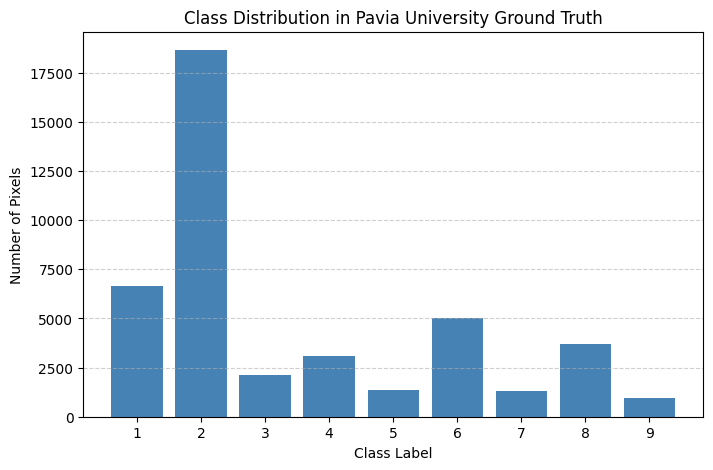

Class 1: 6631 pixels (15.50%)
Class 2: 18649 pixels (43.60%)
Class 3: 2099 pixels (4.91%)
Class 4: 3064 pixels (7.16%)
Class 5: 1345 pixels (3.14%)
Class 6: 5029 pixels (11.76%)
Class 7: 1330 pixels (3.11%)
Class 8: 3682 pixels (8.61%)
Class 9: 947 pixels (2.21%)


In [5]:
labels = Y.flatten()
labels = labels[labels > 0]

# Count frequency of each class
unique, counts = np.unique(labels, return_counts=True)

# Plot as bar chart
plt.figure(figsize=(8, 5))
plt.bar(unique, counts, color='steelblue')
plt.title("Class Distribution in Pavia University Ground Truth")
plt.xlabel("Class Label")
plt.ylabel("Number of Pixels")
plt.xticks(unique)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# print numerical distribution
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} pixels ({c/len(labels)*100:.2f}%)")


The class distribution shows class imbalance between classes. So, Stratified train–test split can be utilized.

### Visualize ground truth classes

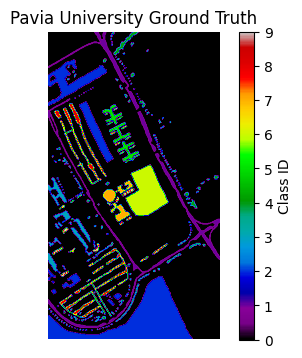

In [6]:
plt.figure(figsize=(5,4))
plt.imshow(Y, cmap='nipy_spectral')
plt.title("Pavia University Ground Truth")
plt.axis('off')
plt.colorbar(label='Class ID')
plt.show()

In [7]:
wavelengths = np.arange(430, 961, 5)[:X.shape[2]]  # ensures 103 wavelengths

rows, cols, bands = X.shape
X_flat = X.reshape(-1, bands)   # (610*340, 103)
Y_flat = Y.flatten()            # (610*340,)

#  Create DataFrame 
columns = [f"{wl}nm" for wl in wavelengths]
df = pd.DataFrame(X_flat, columns=columns)
df["target"] = Y_flat

print("DataFrame shape:", df.shape)
df.head()

DataFrame shape: (207400, 104)


,430nm,435nm,440nm,445nm,450nm,455nm,460nm,465nm,470nm,475nm,...,900nm,905nm,910nm,915nm,920nm,925nm,930nm,935nm,940nm,target
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0


Choose only five bands

In [8]:
selected_columns = ['490nm', '560nm', '650nm', '705nm', '865nm', 'target']
df_selected = df[selected_columns]
df = df_selected

In [9]:
df.tail()

,490nm,560nm,650nm,705nm,865nm,target
207395,325,521,583,614,2065,0
207396,464,582,595,588,2142,0
207397,370,573,566,556,2292,0
207398,422,616,573,523,2249,0
207399,319,543,525,462,2471,0


#### Remove background pixels

In [10]:
df_nonzero = df[df['target'] != 0].copy()

print("Original shape:", df.shape)
print("After removing target=0:", df_nonzero.shape)

Original shape: (207400, 6)
After removing target=0: (42776, 6)


### Without considering class proportion

Here, the assignment of binary values (0 and 1) is done prior to dividing the data into class-wise training and test sets. Doing so does not ensure the required proportion of data from each class in the training and test sets.

Create binary dataset for vegetation and non-vegetation

In [11]:
df_binary = df_nonzero.copy()

# Map target: 2 & 4 -> 1, all others -> 0
df_binary['binary_target'] = df_binary['target'].apply(lambda x: 1 if x in [2, 4] else 0)

print(df_binary['binary_target'].value_counts())

binary_target
1    21713
0    21063
Name: count, dtype: int64


Logistic Regression

In [12]:
X = df_binary.drop(columns=['target', 'binary_target']).values
y = df_binary['binary_target'].values

# Standardize features for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 34220
Test size: 8556


Given the sufficient representation of samples in both classes, the dataset is divided into training and testing sets with an 80:20 ratio.

Test Accuracy: 0.9013557737260403

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      4213
           1       0.86      0.96      0.91      4343

    accuracy                           0.90      8556
   macro avg       0.91      0.90      0.90      8556
weighted avg       0.91      0.90      0.90      8556



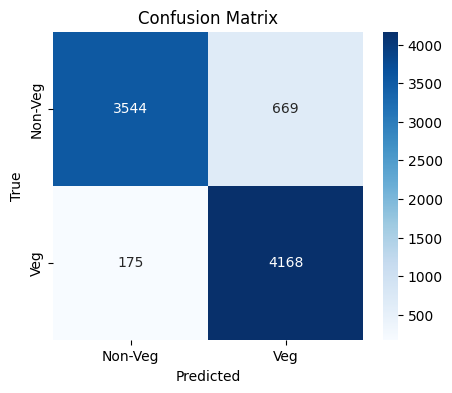

In [14]:
clf = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
clf.fit(X_train, y_train)
# Predict on the test set
y_pred = clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Veg', 'Veg'], yticklabels=['Non-Veg', 'Veg'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Precision measures the proportion of correctly predicted positive samples out of all samples predicted as positive.

$\text{Precision} = \dfrac{TP}{TP + FP}$


Where:  
- \( TP \): True Positives  
- \( FP \): False Positives

Recall measures the proportion of correctly predicted positive samples out of all actual positive samples.

$\text{Recall} = \dfrac{TP}{TP + FN}$


Where:  
- \( FN \): False Negatives 


When class proportions are not considered during the train-test split, there tends to be a large difference between precision and recall values. Classes with larger representation (such as meadows, asphalt, and trees) are more likely to appear in the test set. Due to overrepresentation of meadow class the model learn more separable decision boundaries for the meadows class, resulting in fewer false positives and thus higher precision for vegetation class during testing. 

In contrast, for the non-vegetation class, we observe low precision but high recall. Since the model learns a larger boundary for distinguishing meadows than asphalt, it is more prone to false positives than false negatives, which explains the higher recall and lower precision.

### With considering class proportion 

Here, the data is first divided into training and test sets using stratified sampling, which ensures that the required proportion of data from each class is preserved in both sets. Only after this are the binary values (0 and 1) assigned. This ensures that the original nine classes are well represented in the two-class problem.

In [15]:
df_bal_binary = df_nonzero.copy()
train_df, test_df = train_test_split(
    df_bal_binary,
    test_size=0.2,    # train-test split ratio 80:20
    random_state=42,
    stratify=df_bal_binary['target']  # preserve original class proportions
)

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)

Train size: (34220, 6)
Test size: (8556, 6)


Sample size: Training -> 34220 samples
Testing -> 8556 samples 

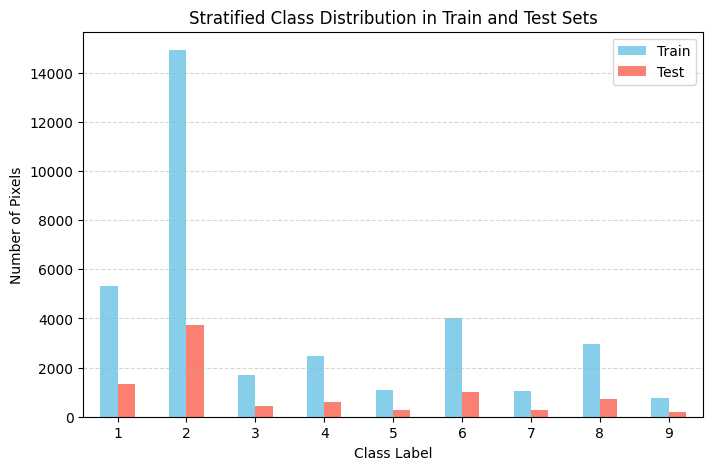

In [16]:
train_counts = train_df['target'].value_counts().sort_index()
test_counts = test_df['target'].value_counts().sort_index()

# Combine into a DataFrame for plotting
dist_df = train_counts.to_frame(name='Train').join(test_counts.to_frame(name='Test'))

# Plot side-by-side bar chart
dist_df.plot(kind='bar', figsize=(8,5), color=['skyblue', 'salmon'])
plt.xlabel('Class Label')
plt.ylabel('Number of Pixels')
plt.title('Stratified Class Distribution in Train and Test Sets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [17]:
def map_to_binary(x):
    return 1 if x in [2, 4] else 0

train_df['binary_target'] = train_df['target'].apply(map_to_binary)
test_df['binary_target'] = test_df['target'].apply(map_to_binary)

print("\nTrain binary distribution:\n", train_df['binary_target'].value_counts(normalize=True))
print("\nTest binary distribution:\n", test_df['binary_target'].value_counts(normalize=True))


Train binary distribution:
 binary_target
1    0.507598
0    0.492402
Name: proportion, dtype: float64

Test binary distribution:
 binary_target
1    0.507597
0    0.492403
Name: proportion, dtype: float64


There is an identical proportion of classes 0 and 1 in both the training and test datasets, indicating that the data for the two classes is balanced.

In [18]:
X_train = train_df.drop(columns=['target', 'binary_target']).values
y_train = train_df['binary_target'].values

X_test = test_df.drop(columns=['target', 'binary_target']).values
y_test = test_df['binary_target'].values

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
clf.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(clf, X, y, dataset_name="Dataset"):
    y_pred = clf.predict(X)
    
    # Overall accuracy
    acc = accuracy_score(y, y_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    
    # Per-class accuracy
    per_class_acc = np.diag(cm) / cm.sum(axis=1)
    mean_per_class_acc = per_class_acc.mean()
    
    # Precision, Recall, F1-score (macro)
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    
    print(f"\nEvaluation on {dataset_name}")
    print(f"Mean Accuracy: {acc:.4f}")
    print(f"Mean Per-Class Accuracy: {mean_per_class_acc:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    
    return y_pred


In [20]:
y_train_pred = evaluate_model(clf, X_train_scaled, y_train, dataset_name="Training Set")
y_test_pred = evaluate_model(clf, X_test_scaled, y_test, dataset_name="Testing Set")


Evaluation on Training Set
Mean Accuracy: 0.9047
Mean Per-Class Accuracy: 0.9038
Precision (macro): 0.9101
Recall (macro): 0.9038
F1-score (macro): 0.9042

Evaluation on Testing Set
Mean Accuracy: 0.8998
Mean Per-Class Accuracy: 0.8990
Precision (macro): 0.9048
Recall (macro): 0.8990
F1-score (macro): 0.8994


When considering class proportion the precision recall is identical for both trianing and testing samples. As required proportion of samples from each class are acquired, the model can develop an unbaised decision boundary and thus resulting in balanced precision and recall. 

Compute the ROC curve and AUC

Test ROC-AUC: 0.9559


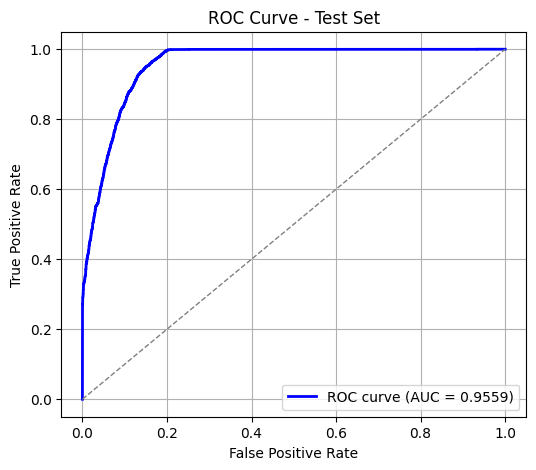

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

y_test_prob = clf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Compute AUC
auc = roc_auc_score(y_test, y_test_prob)
print(f"Test ROC-AUC: {auc:.4f}")
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The high AUC value indicates that the classifier is able to perfectly distinguish between two classes. 

XG Boost

In [22]:
df_xgboost = df_nonzero.copy()
df_xgboost.head()

,490nm,560nm,650nm,705nm,865nm,target
91,1327,1631,1915,1922,1827,1
92,1663,1764,1688,1593,1163,1
93,1182,1056,1034,1013,1113,1
94,927,1016,1185,1357,2069,1
95,1559,2101,2641,2628,1882,1


Here same number of features as problem 1 have been utilized to train XGBoost model.

In [23]:
from xgboost import XGBClassifier

X = df_xgboost.drop(columns=['target'])
y = df_xgboost['target'] - 1  # Make sure labels start from 0 (i.e., 0–8)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()

# Fit on training set only
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
xgb_multi = XGBClassifier(
    objective='multi:softmax',   # or 'multi:softprob' for probabilities
    num_class=9,                 # number of classes
    eval_metric='mlogloss',
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_multi.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=9, num_parallel_tree=None, ...)

Feature importance plot

<Figure size 1000x800 with 0 Axes>

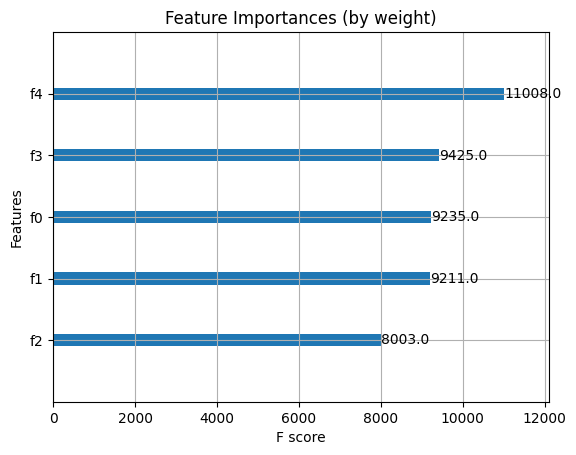

In [24]:
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_multi, importance_type='weight', max_num_features=10)  # top 10 (among 103) features by gain
plt.title('Feature Importances (by weight)')
plt.show()


Confusion matrix

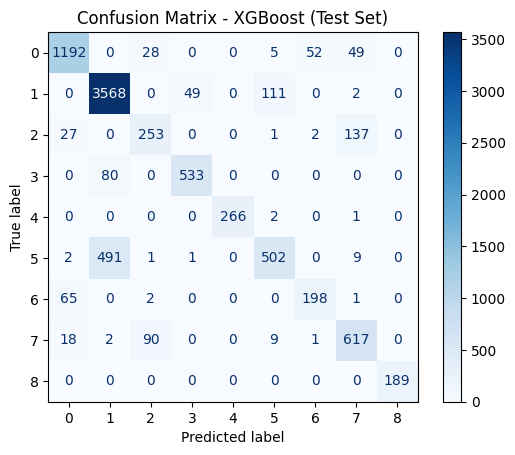

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = xgb_multi.predict(X_test_scaled)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_multi.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost (Test Set)")
plt.show()

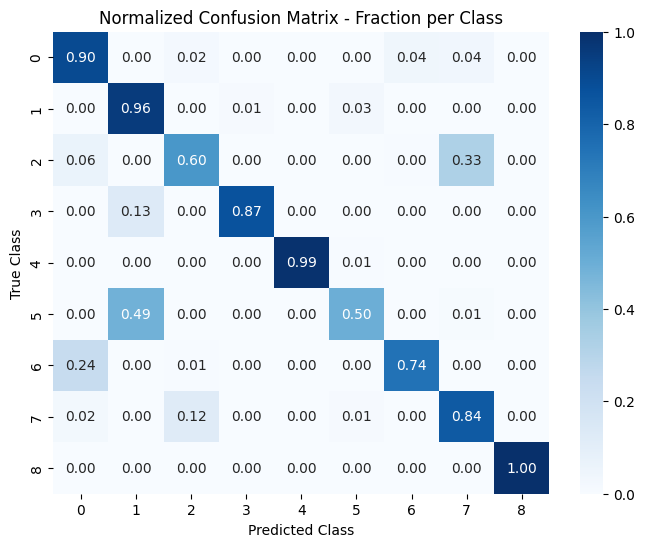

In [26]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Normalized Confusion Matrix - Fraction per Class")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


In [27]:
mean_accuracy = accuracy_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Mean per-class accuracy 
# accuracy per class = correct predictions for class_i / total samples in class_i
per_class_acc = cm.diagonal() / cm.sum(axis=1)
mean_per_class_acc = np.mean(per_class_acc)

# Precision, Recall, F1 (per class and average)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Per-Class Accuracy: {mean_per_class_acc:.4f}")
print("\nDetailed Report:\n")
print(report_df)

Mean Accuracy: 0.8553
Mean Per-Class Accuracy: 0.8219

Detailed Report:

              precision    recall  f1-score      support
0              0.914110  0.898944  0.906464  1326.000000
1              0.861628  0.956568  0.906619  3730.000000
2              0.676471  0.602381  0.637280   420.000000
3              0.914237  0.869494  0.891304   613.000000
4              1.000000  0.988848  0.994393   269.000000
5              0.796825  0.499006  0.613692  1006.000000
6              0.782609  0.744361  0.763006   266.000000
7              0.756127  0.837178  0.794591   737.000000
8              1.000000  1.000000  1.000000   189.000000
accuracy       0.855306  0.855306  0.855306     0.855306
macro avg      0.855779  0.821864  0.834150  8556.000000
weighted avg   0.852685  0.855306  0.848542  8556.000000


### Data balancing -> Downsampling

In [28]:
df_xgboost = df_nonzero.copy()
df_xgboost.head()

,490nm,560nm,650nm,705nm,865nm,target
91,1327,1631,1915,1922,1827,1
92,1663,1764,1688,1593,1163,1
93,1182,1056,1034,1013,1113,1
94,927,1016,1185,1357,2069,1
95,1559,2101,2641,2628,1882,1


In [29]:
class_9_count = (df_xgboost['target'] == 9).sum()
print("Number of samples with target value 9:", class_9_count)


Number of samples with target value 9: 947


Since there is a large imbalance in the number of samples between classes, the data has been undersampled to match minority class size. After downsampling, the number of samples in each class is 947.

### Undersampling

In [30]:
# from sklearn.utils import resample

# majority_class = 2  # example, Class 2
# fraction = 0.34     # reduce by 34%

# # Separate majority class
# majority_df = df_xgboost[df_xgboost['target'] == majority_class]
# other_df = df_xgboost[df_xgboost['target'] != majority_class]

# # Downsample the majority class by fraction
# majority_down = resample(
#     majority_df,
#     replace=False,
#     n_samples=int(len(majority_df) * fraction),
#     random_state=42
# )

# # Combine with the other classes
# df_new = pd.concat([majority_down, other_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# # Check new distribution
# print("New class counts:\n", df_new['target'].value_counts().sort_index())

In [31]:
target_count = 947

# Downsample each class to 947 samples
df_new = (
    df_xgboost
    .groupby('target', group_keys=False)
    .apply(lambda x: x.sample(n=target_count, random_state=42))
    .reset_index(drop=True)
)

print(df_new['target'].value_counts())


target
1    947
2    947
3    947
4    947
5    947
6    947
7    947
8    947
9    947
Name: count, dtype: int64


/tmp/ipykernel_651779/3320971126.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xgboost


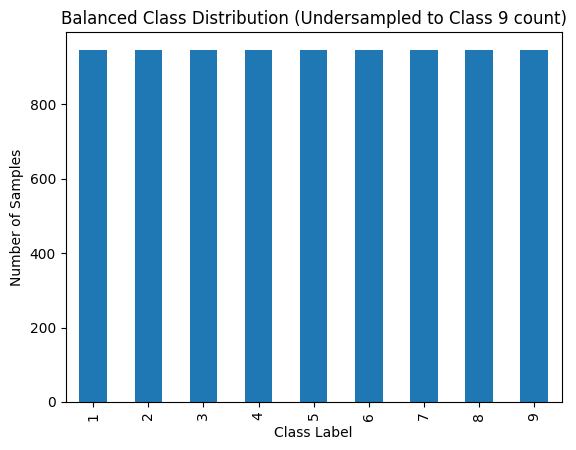

In [32]:
df_new['target'].value_counts().sort_index().plot(kind='bar')
plt.title("Balanced Class Distribution (Undersampled to Class 9 count)")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()

In [33]:
X = df_new.drop(columns=['target'])
y = df_new['target'] - 1  # Make sure labels start from 0 (i.e., 0–8)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()

# Fit on training set only
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
xgb_multi = XGBClassifier(
    objective='multi:softmax',   # or 'multi:softprob' for probabilities
    num_class=9,                 # number of classes
    eval_metric='mlogloss',
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_multi.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=9, num_parallel_tree=None, ...)

Feature plot

<Figure size 1000x800 with 0 Axes>

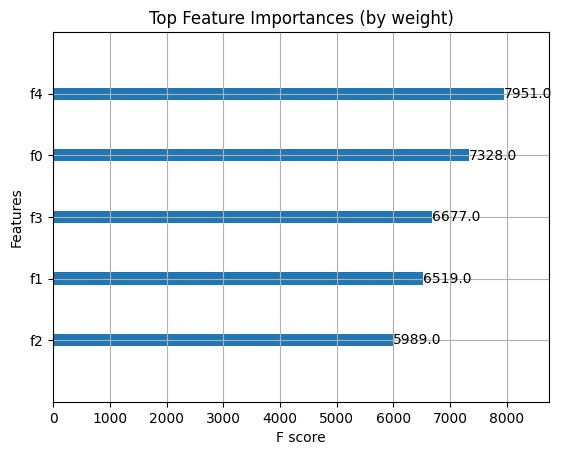

In [34]:
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_multi, importance_type='weight', max_num_features=10)  # top 10 features by gain
plt.title('Top Feature Importances (by weight)')
plt.show()

The feature importance plot showcases the important features in order. The feature number 4 (near-infrared) is found to be important feature for classification followed by 0 (blue) and 1 (red). It is because the larger numner of pixels (meadows) shows large reflection in NIR region represented by fourth feature.

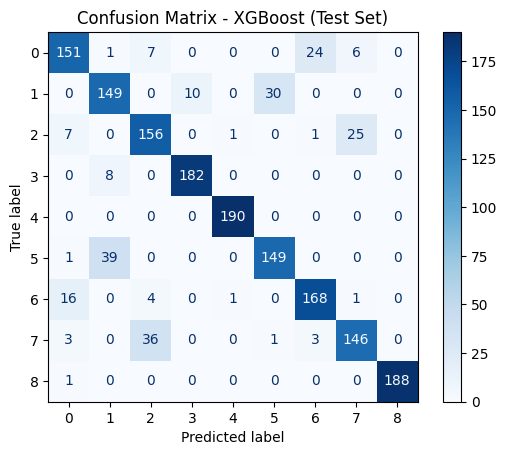

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = xgb_multi.predict(X_test_scaled)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_multi.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost (Test Set)")
plt.show()


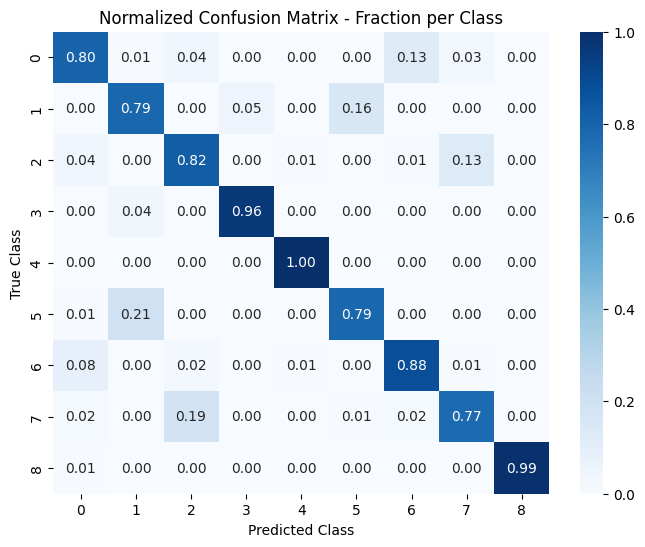

In [36]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Normalized Confusion Matrix - Fraction per Class")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


Here class 2 (class 1 in confusion matrix) is being confused as being 6 (class 5 in confusion matrix). These classes are meadows and soil. This is because these two materical exhibit same spectral signature for the choosen bands. Similarly, there is also confusion between Gravel and self-blocking bricks as they may have similar material properties. 

In [37]:
mean_accuracy = accuracy_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Mean per-class accuracy
# accuracy per class = correct predictions for class_i / total samples in class_i
per_class_acc = cm.diagonal() / cm.sum(axis=1)
mean_per_class_acc = np.mean(per_class_acc)

# Precision, Recall, F1 (per class and average)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Per-Class Accuracy: {mean_per_class_acc:.4f}")
print("\nDetailed Report:\n")
print(report_df)

Mean Accuracy: 0.8674
Mean Per-Class Accuracy: 0.8673

Detailed Report:

              precision    recall  f1-score      support
0              0.843575  0.798942  0.820652   189.000000
1              0.756345  0.788360  0.772021   189.000000
2              0.768473  0.821053  0.793893   190.000000
3              0.947917  0.957895  0.952880   190.000000
4              0.989583  1.000000  0.994764   190.000000
5              0.827778  0.788360  0.807588   189.000000
6              0.857143  0.884211  0.870466   190.000000
7              0.820225  0.772487  0.795640   189.000000
8              1.000000  0.994709  0.997347   189.000000
accuracy       0.867449  0.867449  0.867449     0.867449
macro avg      0.867893  0.867335  0.867250  1705.000000
weighted avg   0.867947  0.867449  0.867334  1705.000000


A simple approach of randomly downsampling the majority classes to match the proportions of minority class improved the mean class accuracy by 5.5%. Other approaches, such as oversampling and SMOTE, can also be employed depending on the nature of the data and the problem requirements.

There was a large margin between precision and recall before balancing the data, particularly for class 6 (represented as 5 in the confusion matrix). After data balancing, this difference has decreased significantly. The precision and recall are now more balanced, indicating that the model’s ability to identify positive samples and its accuracy in predicting positives are comparably strong.

### Regression

In [38]:
import numpy as np

# Load the data
X = np.load('landis_chlorophyl_regression.npy')
y = np.load('landis_chlorophyl_regression_gt.npy')

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1000, 10)
y shape: (1000,)


EDA

In [39]:
print("Data type:", X.dtype)
print("Ground truth type:", y.dtype)

print("\nX summary:")
print("  Min:", np.min(X))
print("  Max:", np.max(X))
print("  Mean:", np.mean(X))
print("  Std:", np.std(X))

print("\ny summary:")
print("  Min:", np.min(y))
print("  Max:", np.max(y))
print("  Mean:", np.mean(y))
print("  Std:", np.std(y))


Data type: float64
Ground truth type: float64

X summary:
  Min: 21.118434995442527
  Max: 121.76891403260653
  Mean: 50.98832065303078
  Std: 21.474362004098783

y summary:
  Min: 1.0502608279721377
  Max: 79.84666034713156
  Mean: 40.42283372218778
  Std: 22.66210493530633


As this is a regression problem, the statistics of the dataset being utilized are important. Therefore, a statistical summary is derived. The shape of the data is also displayed to visualize the number of features and the sample size.

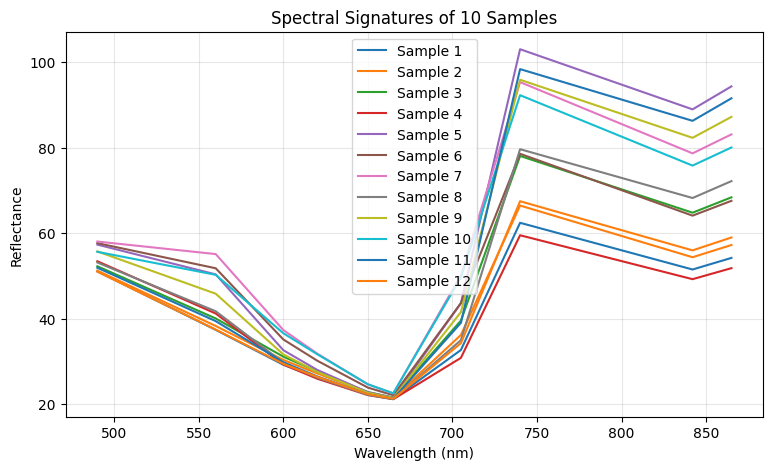

In [40]:
import matplotlib.pyplot as plt

band_names = [
    'Blue', 'Green', 'Yellow', 'Orange', 'Red 1', 
    'Red 2', 'Red Edge 1', 'Red Edge 2', 'NIR_Broad', 'NIR1'
]
center_wavelengths = [490, 560, 600, 620, 650, 665, 705, 740, 842, 865]

# Plot first 10 spectra
plt.figure(figsize=(9, 5))
for i in range(12):
    plt.plot(center_wavelengths, X[i], label=f'Sample {i+1}')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Spectral Signatures of 10 Samples')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


There is a smooth transition from blue to green wavelengths. A noticeable dip appears in the red region (660 nm) due to strong chlorophyll absorption. As vegetation reflects strongly in the red edge and near infrared (NIR) region, a sharp increase in reflectance is observed. Reflectance values in the 750–850 nm and 490-560 nm, and 600-650 nm range are nearly identical, suggesting a high correlation among bands in this region.

Multicolinearity identification

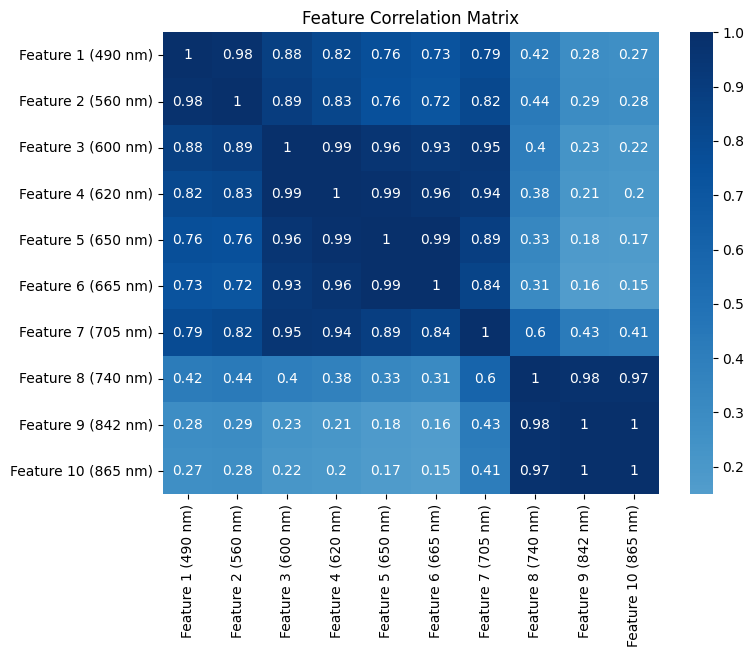

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to DataFrame for easier handling
df_X = pd.DataFrame(X, columns=[f'Feature {i+1} ({center_wavelengths[i]} nm)' for i in range(X.shape[1])])

# Compute correlation matrix
corr = df_X.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='Blues', center=0)
plt.title('Feature Correlation Matrix')
plt.show()


There is a noticeable correlation between features 1 and 2 (Blue, 490 nm, and Green, 560 nm); between features 3, 4, 5, and 6 (Yellow, 600 nm; Orange, 620 nm; Red1, 650 nm; and Red2, 665 nm); and between features 8, 9, and 10 (Red Edge 2, 740 nm; NIR_Broad, 842 nm; and NIR1, 865 nm). This pattern is also evident in the spectral signature plot above, where major transitions occur primarily between these wavelength ranges.

In [42]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Convert to DataFrame for easier handling
# df_X = pd.DataFrame(X, columns=[f'Feature {i+1} ({center_wavelengths[i]})' for i in range(X.shape[1])])

# # Compute correlation matrix
# corr = df_X.corr()

# plt.figure(figsize=(8,6))
# sns.heatmap(corr, annot=True, cmap='Blues', center=0)
# plt.title('Feature Correlation Matrix')
# plt.show()


Data distribution

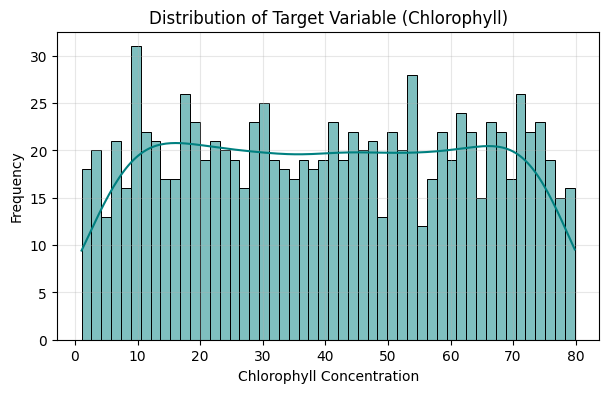

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(7, 4))
sns.histplot(y, bins=50, kde=True, color='teal')
plt.title('Distribution of Target Variable (Chlorophyll)')
plt.xlabel('Chlorophyll Concentration')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


The distribution of target/output variable looks balanced. 

## Linear Regression

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [45]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [46]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#  TRAIN METRICS 
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
residuals_train = y_train - y_train_pred
std_resid_train = np.std(residuals_train)

#  TEST METRICS 
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
residuals_test = y_test - y_test_pred
std_resid_test = np.std(residuals_test)

# PRINT RESULTS 
print("TRAINING SET METRICS:")
print(f"  Mean Absolute Error (MAE): {mae_train:.4f}")
print(f"  R-squared (R²): {r2_train:.4f}")
print(f"  Std of Residuals: {std_resid_train:.4f}\n")

print("TESTING SET METRICS:")
print(f"  Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"  R-squared (R²): {r2_test:.4f}")
print(f"  Std of Residuals: {std_resid_test:.4f}")


TRAINING SET METRICS:
  Mean Absolute Error (MAE): 4.1442
  R-squared (R²): 0.9389
  Std of Residuals: 5.5521

TESTING SET METRICS:
  Mean Absolute Error (MAE): 4.5318
  R-squared (R²): 0.9262
  Std of Residuals: 6.3638


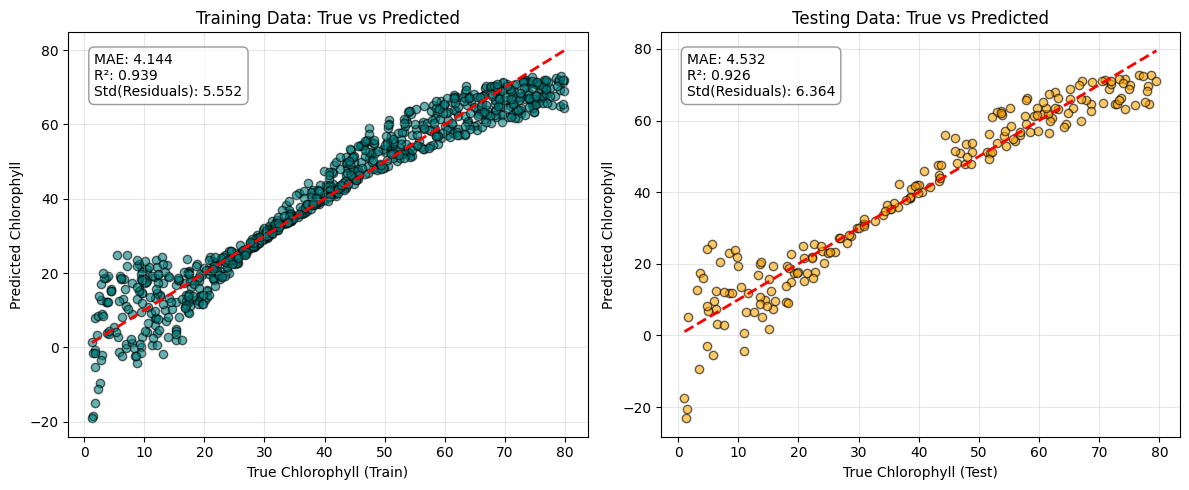

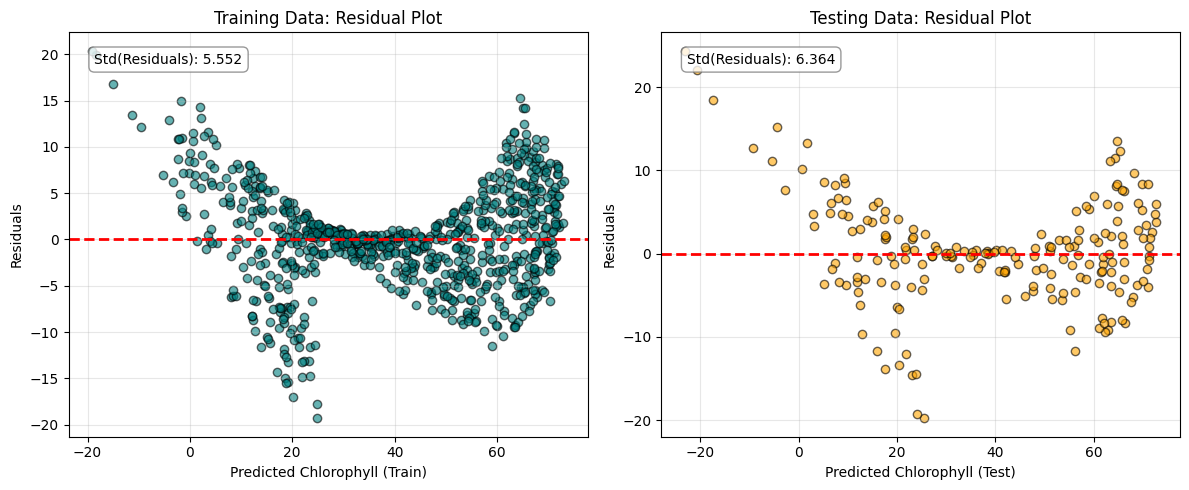

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Residuals
resid_train = y_train - y_train_pred
resid_test = y_test - y_test_pred

# Compute metrics 
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    std_resid = np.std(y_true - y_pred)
    return mae, r2, std_resid

mae_train, r2_train, std_train = regression_metrics(y_train, y_train_pred)
mae_test, r2_test, std_test = regression_metrics(y_test, y_test_pred)

#  REGRESSION PLOTS

plt.figure(figsize=(12, 5))

# Training 
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6, color='teal', edgecolor='k')
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'r--', lw=2)
plt.xlabel("True Chlorophyll (Train)")
plt.ylabel("Predicted Chlorophyll")
plt.title("Training Data: True vs Predicted")
plt.grid(True, alpha=0.3)

# Add metrics box
train_text = (f"MAE: {mae_train:.3f}\n"
              f"R²: {r2_train:.3f}\n"
              f"Std(Residuals): {std_train:.3f}")
plt.text(0.05, 0.95, train_text, transform=plt.gca().transAxes,
         fontsize=10, va='top', bbox=dict(boxstyle="round,pad=0.4", 
         fc="white", ec="gray", alpha=0.8))

# Testing
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='orange', edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("True Chlorophyll (Test)")
plt.ylabel("Predicted Chlorophyll")
plt.title("Testing Data: True vs Predicted")
plt.grid(True, alpha=0.3)

# Add metrics box
test_text = (f"MAE: {mae_test:.3f}\n"
             f"R²: {r2_test:.3f}\n"
             f"Std(Residuals): {std_test:.3f}")
plt.text(0.05, 0.95, test_text, transform=plt.gca().transAxes,
         fontsize=10, va='top', bbox=dict(boxstyle="round,pad=0.4",
         fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# RESIDUAL PLOTS

plt.figure(figsize=(12, 5))

# Train residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, resid_train, alpha=0.6, color='teal', edgecolor='k')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Chlorophyll (Train)")
plt.ylabel("Residuals")
plt.title("Training Data: Residual Plot")
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f"Std(Residuals): {std_train:.3f}",
         transform=plt.gca().transAxes, fontsize=10, va='top',
         bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.8))

# Test residuals 
plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, resid_test, alpha=0.6, color='orange', edgecolor='k')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Chlorophyll (Test)")
plt.ylabel("Residuals")
plt.title("Testing Data: Residual Plot")
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f"Std(Residuals): {std_test:.3f}",
         transform=plt.gca().transAxes, fontsize=10, va='top',
         bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()


The data in the mid range fit the line, while the points at both ends show greater scatter. The high residual values and the clear pattern indicate poor model performance. Overall, the model does not fit the data well, and both the mean absolute error and R² are quite high.

### Partial Least Squares Regression (PLSR)

In [48]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

r2_train_scores = []

# Test components from 1 to 10
for n_comp in range(1, 11):
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X_train, y_train)
    y_train_pred = pls.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    r2_train_scores.append(r2_train)

# Display results
for i, r2 in enumerate(r2_train_scores, start=1):
    print(f"Components: {i}, Training R²: {r2:.4f}")

best_n = np.argmax(r2_train_scores) + 1
print(f"\nBest number of components: {best_n} (R² = {r2_train_scores[best_n-1]:.4f})")


Components: 1, Training R²: 0.6561
Components: 2, Training R²: 0.7124
Components: 3, Training R²: 0.9091
Components: 4, Training R²: 0.9114
Components: 5, Training R²: 0.9179
Components: 6, Training R²: 0.9194
Components: 7, Training R²: 0.9291
Components: 8, Training R²: 0.9384
Components: 9, Training R²: 0.9388
Components: 10, Training R²: 0.9389

Best number of components: 10 (R² = 0.9389)


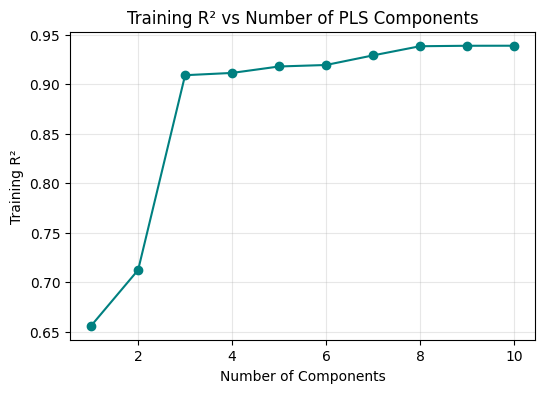

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, 11), r2_train_scores, marker='o', color='teal')
plt.title("Training R² vs Number of PLS Components")
plt.xlabel("Number of Components")
plt.ylabel("Training R²")
plt.grid(True, alpha=0.3)
plt.show()


Using the best-performing component count to generate same regression and residual plots

In [50]:
pls_best = PLSRegression(n_components=best_n)
pls_best.fit(X_train, y_train)

# Predictions
y_train_pred = pls_best.predict(X_train).ravel()
y_test_pred = pls_best.predict(X_test).ravel()

# Residuals
resid_train = y_train - y_train_pred
resid_test = y_test - y_test_pred


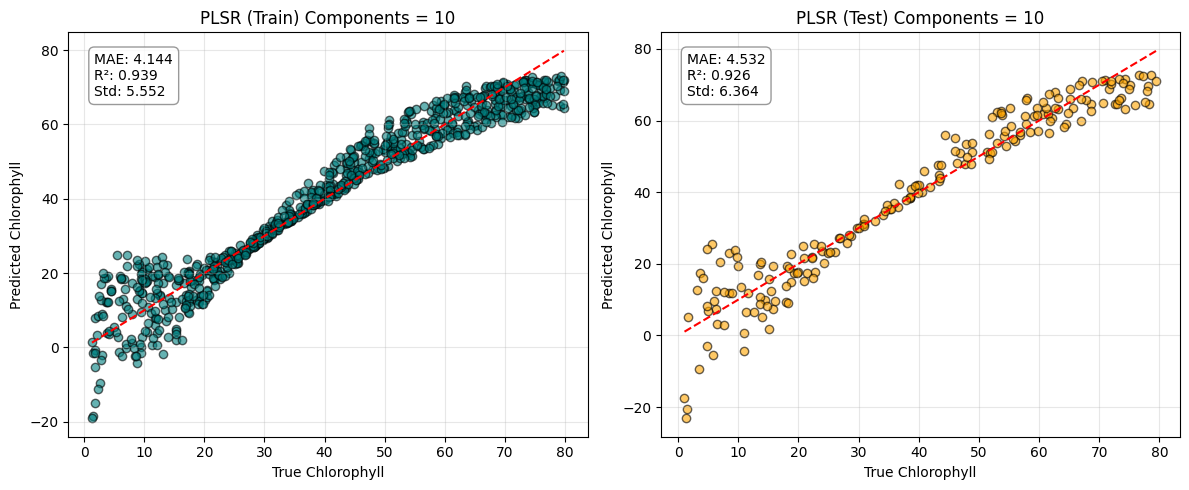

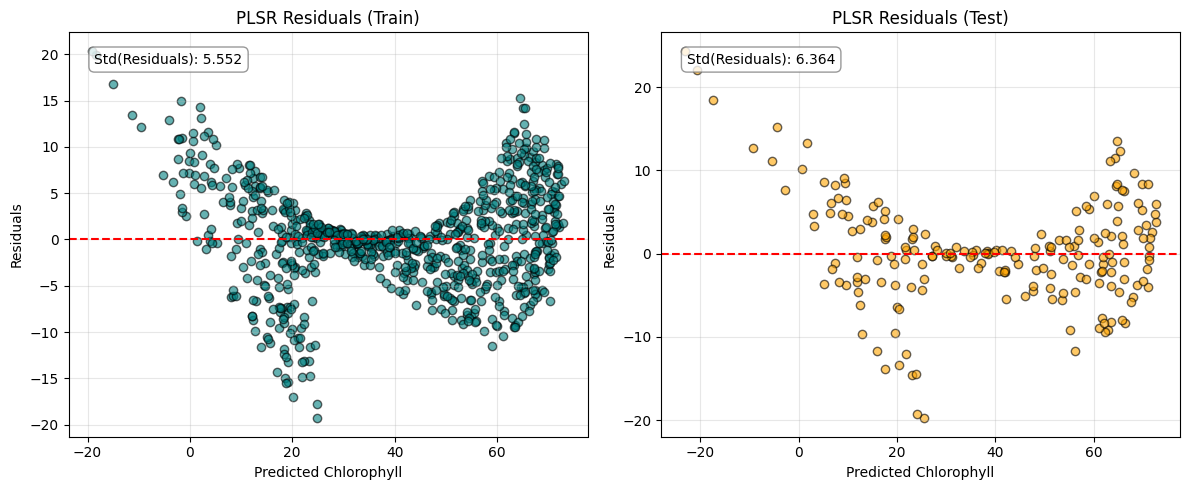

In [51]:
from sklearn.metrics import mean_absolute_error

# Compute metrics function
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    std_resid = np.std(y_true - y_pred)
    return mae, r2, std_resid

mae_train, r2_train, std_train = regression_metrics(y_train, y_train_pred)
mae_test, r2_test, std_test = regression_metrics(y_test, y_test_pred)

#  Regression Plots
plt.figure(figsize=(12,5))

# Train
plt.subplot(1,2,1)
plt.scatter(y_train, y_train_pred, color='teal', alpha=0.6, edgecolor='k')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title(f"PLSR (Train) Components = {best_n}")
plt.xlabel("True Chlorophyll")
plt.ylabel("Predicted Chlorophyll")
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f"MAE: {mae_train:.3f}\nR²: {r2_train:.3f}\nStd: {std_train:.3f}",
         transform=plt.gca().transAxes, fontsize=10, va='top',
         bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.8))

# Test
plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred, color='orange', alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"PLSR (Test) Components = {best_n}")
plt.xlabel("True Chlorophyll")
plt.ylabel("Predicted Chlorophyll")
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f"MAE: {mae_test:.3f}\nR²: {r2_test:.3f}\nStd: {std_test:.3f}",
         transform=plt.gca().transAxes, fontsize=10, va='top',
         bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Residual Plots
plt.figure(figsize=(12,5))

# Train residuals
plt.subplot(1,2,1)
plt.scatter(y_train_pred, resid_train, color='teal', alpha=0.6, edgecolor='k')
plt.axhline(0, color='r', linestyle='--')
plt.title("PLSR Residuals (Train)")
plt.xlabel("Predicted Chlorophyll")
plt.ylabel("Residuals")
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f"Std(Residuals): {std_train:.3f}",
         transform=plt.gca().transAxes, fontsize=10, va='top',
         bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.8))

# Test residuals
plt.subplot(1,2,2)
plt.scatter(y_test_pred, resid_test, color='orange', alpha=0.6, edgecolor='k')
plt.axhline(0, color='r', linestyle='--')
plt.title("PLSR Residuals (Test)")
plt.xlabel("Predicted Chlorophyll")
plt.ylabel("Residuals")
plt.grid(True, alpha=0.3)
plt.text(0.05, 0.95, f"Std(Residuals): {std_test:.3f}",
         transform=plt.gca().transAxes, fontsize=10, va='top',
         bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()


There is a clear pattern in the residual plot, with high residual values. The mean absolute error and R-squared are also high, indicating that the model does not fit the data well. Since the best performance is obtained when using all 10 components, the performance between Partial Least Squares Regression (PLSR) and linear regression is identical.

### Multiple Layer Perceptron (MLP)

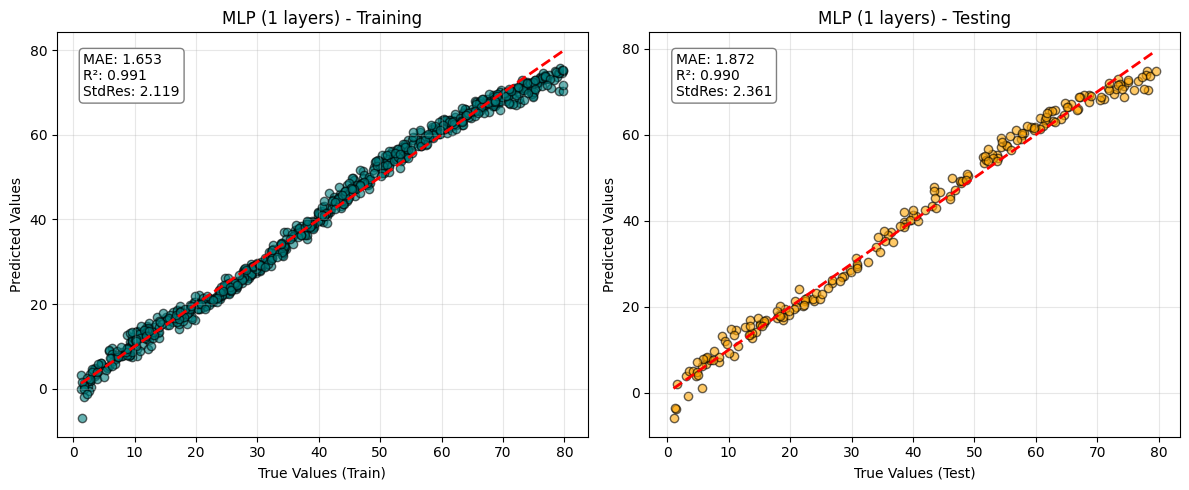

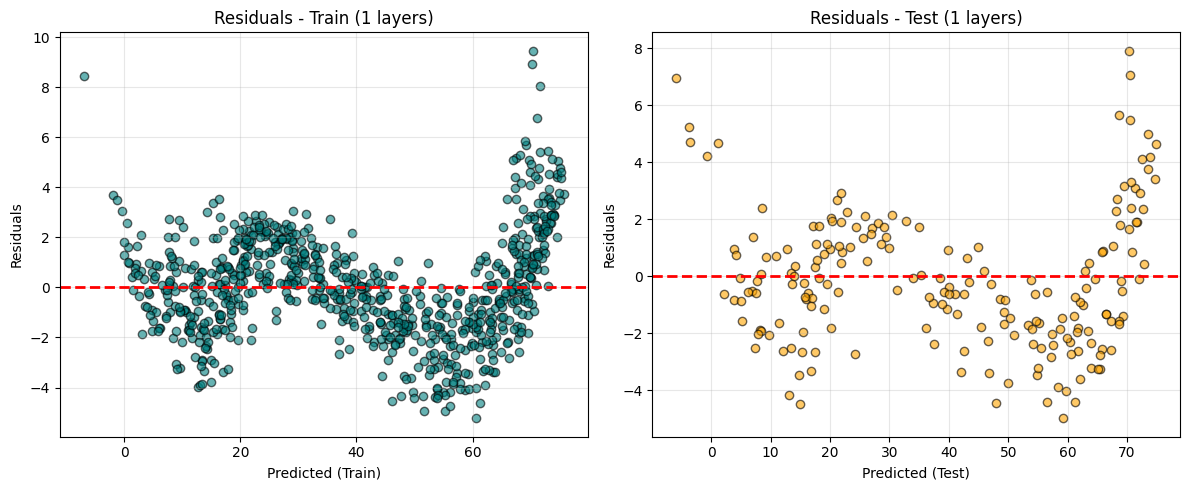

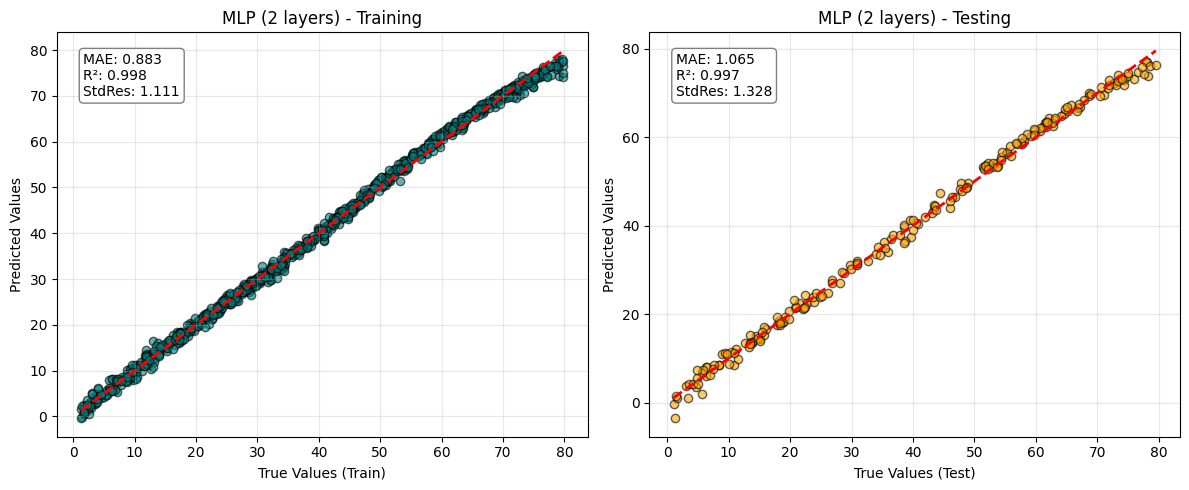

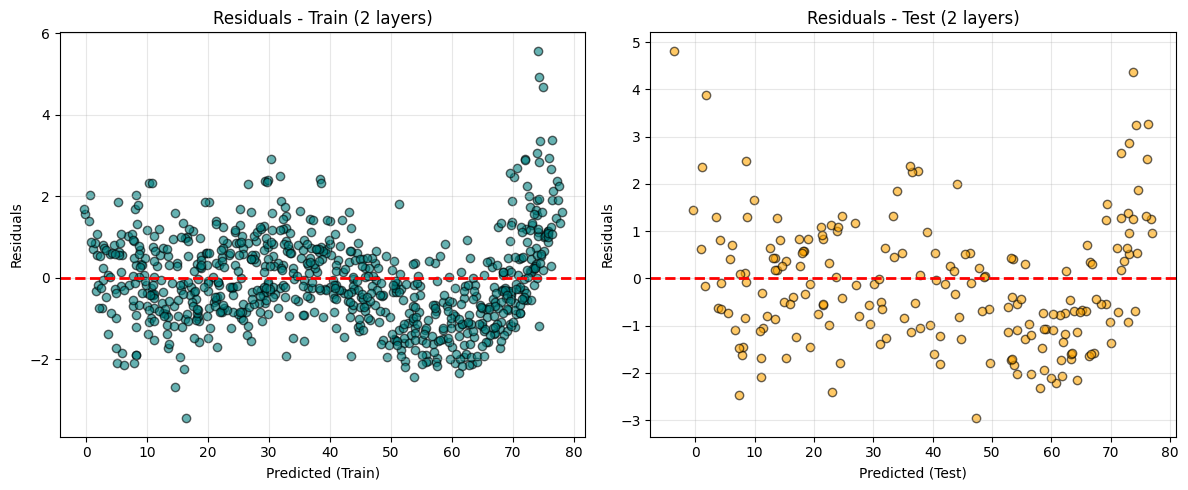

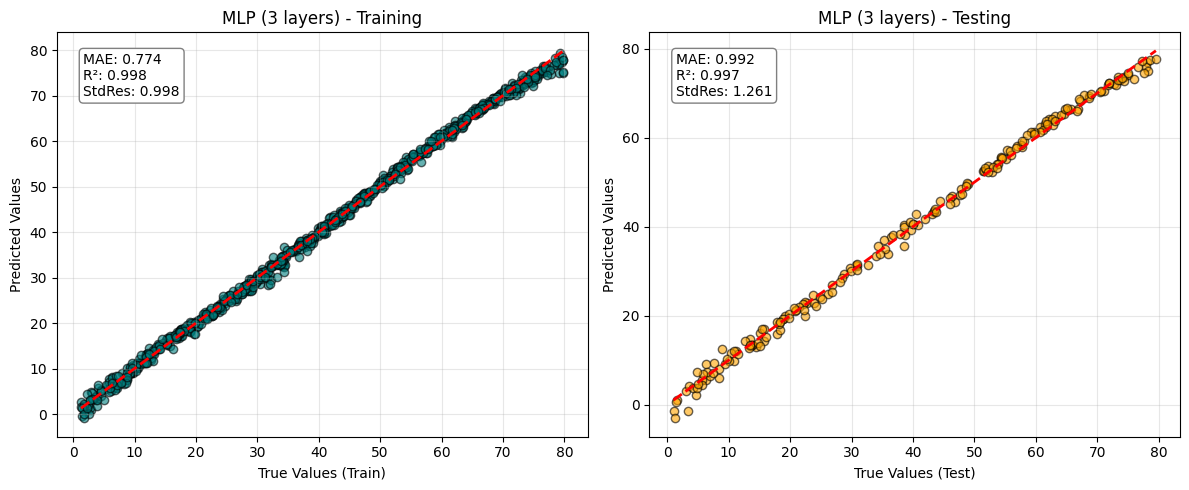

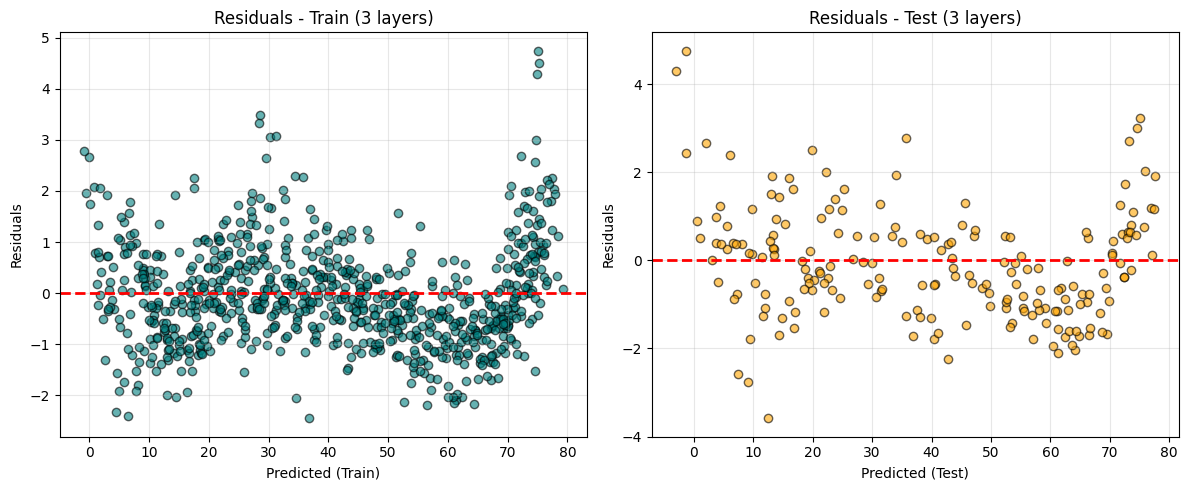

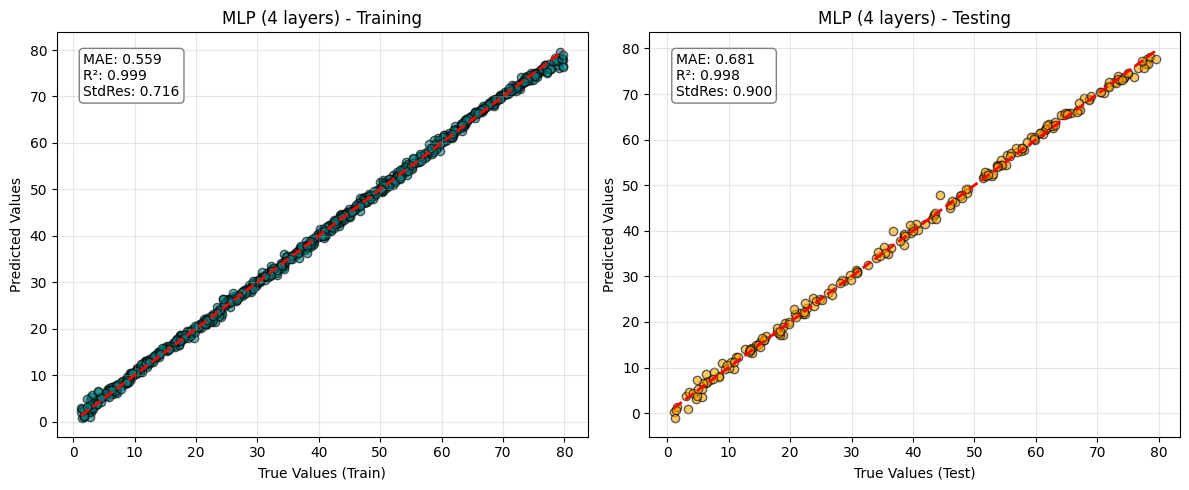

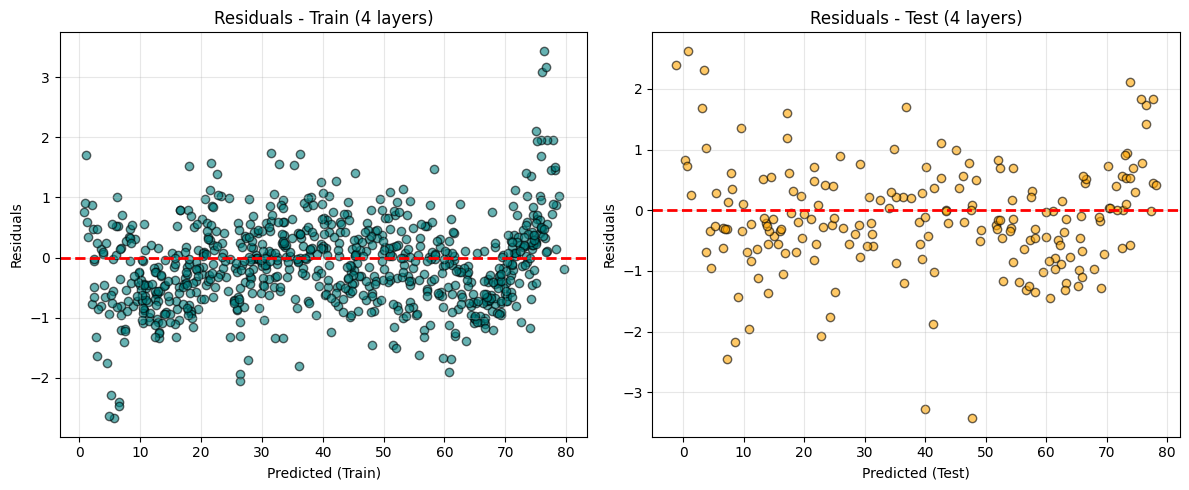

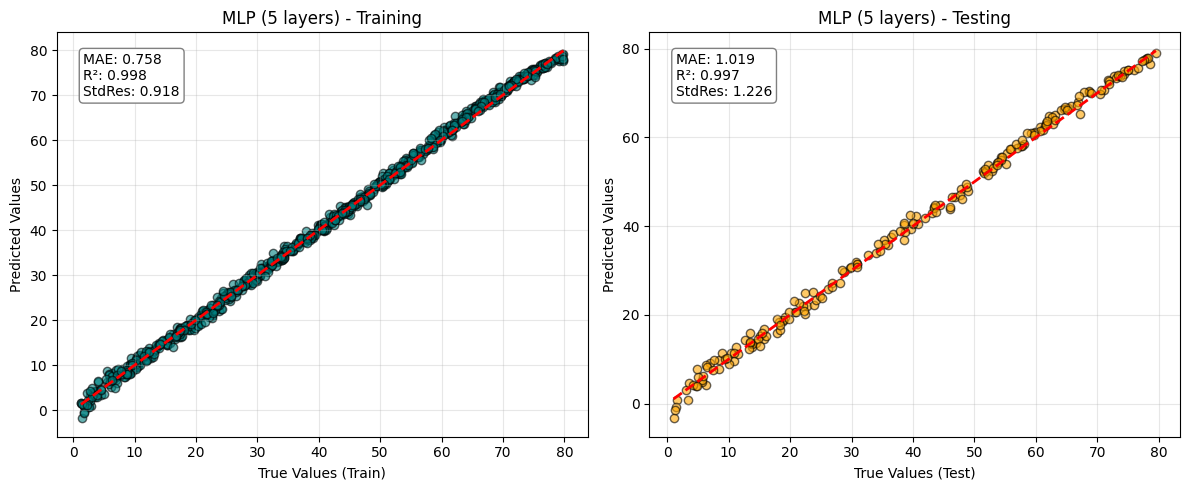

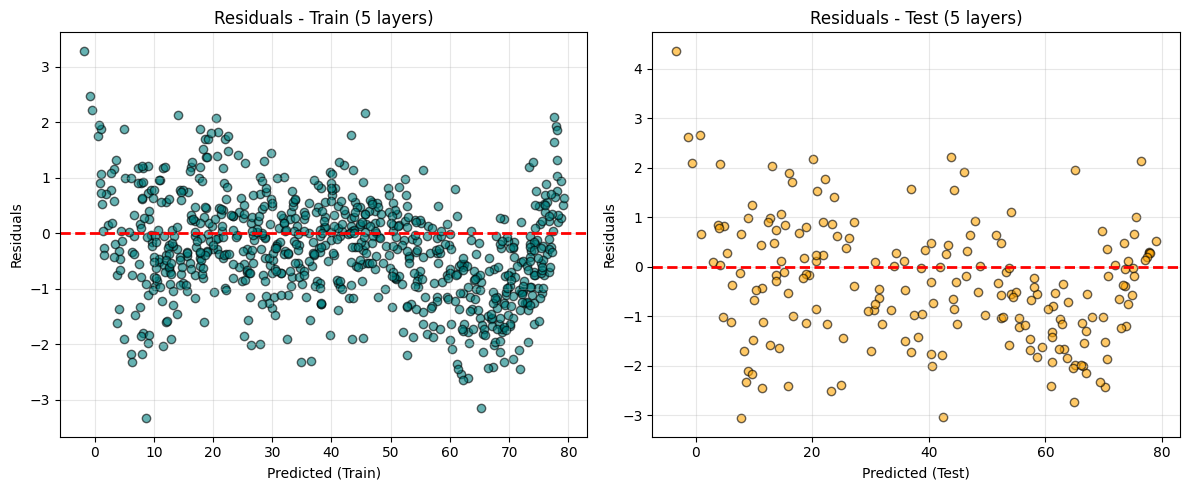

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Standardize data 
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

#  Function to compute metrics 
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    std_resid = np.std(y_true - y_pred)
    return mae, r2, std_resid

# To store results 
results = []

# Loop over different layer counts 
for n_layers in range(1, 6):
    # Create hidden layer sizes (each layer has 64 neurons)
    hidden_layers = tuple([64] * n_layers)
    
    # Initialize and fit model
    model = MLPRegressor(hidden_layer_sizes=hidden_layers,
                         activation='relu',
                         solver='adam',
                         max_iter=2000,
                         random_state=42)
    
    model.fit(X_train_scaled, y_train_scaled)
    
    # Predict
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Inverse scale to original range
    y_train_pred_inv = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()
    y_test_pred_inv = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()
    
    # Metrics
    mae_train, r2_train, std_train = compute_metrics(y_train, y_train_pred_inv)
    mae_test, r2_test, std_test = compute_metrics(y_test, y_test_pred_inv)
    results.append((n_layers, mae_train, r2_train, std_train, mae_test, r2_test, std_test))
    
    # Plotting
    plt.figure(figsize=(12, 5))
    
    # Regression plot (Train/Test)
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred_inv, alpha=0.6, color='teal', edgecolor='k')
    plt.plot([y_train.min(), y_train.max()],
             [y_train.min(), y_train.max()], 'r--', lw=2)
    plt.xlabel("True Values (Train)")
    plt.ylabel("Predicted Values")
    plt.title(f"MLP ({n_layers} layers) - Training")
    plt.text(0.05, 0.95,
             f"MAE: {mae_train:.3f}\nR²: {r2_train:.3f}\nStdRes: {std_train:.3f}",
             transform=plt.gca().transAxes, va='top',
             bbox=dict(boxstyle='round', fc='white', ec='gray'))
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred_inv, alpha=0.6, color='orange', edgecolor='k')
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel("True Values (Test)")
    plt.ylabel("Predicted Values")
    plt.title(f"MLP ({n_layers} layers) - Testing")
    plt.text(0.05, 0.95,
             f"MAE: {mae_test:.3f}\nR²: {r2_test:.3f}\nStdRes: {std_test:.3f}",
             transform=plt.gca().transAxes, va='top',
             bbox=dict(boxstyle='round', fc='white', ec='gray'))
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Residual plots
    plt.figure(figsize=(12, 5))
    resid_train = y_train - y_train_pred_inv
    resid_test = y_test - y_test_pred_inv
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred_inv, resid_train, alpha=0.6, color='teal', edgecolor='k')
    plt.axhline(0, color='r', linestyle='--', lw=2)
    plt.xlabel("Predicted (Train)")
    plt.ylabel("Residuals")
    plt.title(f"Residuals - Train ({n_layers} layers)")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_pred_inv, resid_test, alpha=0.6, color='orange', edgecolor='k')
    plt.axhline(0, color='r', linestyle='--', lw=2)
    plt.xlabel("Predicted (Test)")
    plt.ylabel("Residuals")
    plt.title(f"Residuals - Test ({n_layers} layers)")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



In [53]:
# Display metrics summary 
import pandas as pd
df_results = pd.DataFrame(results, columns=[
    "Layers", "MAE_Train", "R2_Train", "StdRes_Train",
    "MAE_Test", "R2_Test", "StdRes_Test"
])
print(df_results)

   Layers  MAE_Train  R2_Train  StdRes_Train  MAE_Test   R2_Test  StdRes_Test
0       1   1.653473  0.991099      2.118673  1.872474  0.989811     2.360755
1       2   0.882527  0.997538      1.111169  1.064976  0.996765     1.327951
2       3   0.774416  0.998017      0.997985  0.991615  0.997096     1.260605
3       4   0.558917  0.998952      0.716406  0.680537  0.998495     0.900243
4       5   0.758482  0.998149      0.918464  1.019000  0.997052     1.226419


Here, MLP networks with 1 to 5 layers, each containing 64 neurons, were implemented. The best model, achieving a mean absolute error of 0.680537 on the test set, was obtained with 4 layers. Models with one or two layers exhibit a curved pattern, indicating insufficient non-linearity to capture the inherent patterns in the data. As the number of layers increases (model complexity and non-linearity), the residuals scatter more randomly around zero, indicating a better fit to the data.

The linear regression and Partial Least Squares Regression (PLSR) models could not fit the data well, indicating high bias. In contrast, the MLP model fits the data very well and exhibits low bias, with comparable performance on both training and testing sets. However, a complex model that fits the training data closely may perform poorly when exposed to noisy or slightly different data, resulting in a significant drop in performance. This situation corresponds to a high-variance model. Therefore, careful evaluation of the model is necessary.